# Photometry of an open cluster

This juypter notebook consist of the scripts necessary to calculate the color-magnitude diagram of an open cluster. The individual scripts here assume perfectly calibrated and reduced (hence bias-, flat- and dark-frame corrected) observations. In case the calibrations were not done completely, some scripts (especially the star finding) may not work properly.

#### Steps of analysis:

- Star detection

- Photometry:
    - Aperture size calculation
    - Measuring counts

- Calibrating photometry zero-point

### Disclaimer / important information
This pipeline perform the very basic photometry all objects in the figure. Whereas this is perfectly enough for this exercise and it shows the backbone principle of the analysis, this is in no way reflects the state of the art stage of photometry: the procedure itself can be improved in several ways. Feel free to experiment with different setups and methods in this notebook; this initial version is just an example of how the photometry can be performed.

# **Ideally, you will need to add this notebook to your Google Drive to be able to modify it. Otherwise you will not be able to set e.g. the path to the observation files.**

Before starting anything, mount your Google Drive on Colab, so that you can access the files. This will import the file system of your drive to Google Colab. In case you are uncomfortable with using Drive, you can also upload the data manually, or upload it to a data repository then wget it from there.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First try to download the required kernel for this notebook. When started, the notebook will drop an error message of the kernel not being recognized; don't worry about this.

In [ ]:
!wget -c https://raw.githubusercontent.com/Csogeza/FoPra85/main/environment.txt
!pip install -r environment.txt

### As a first step, the relevant python packages have to be imported.
It is assumed, that these are already installed for the python environment that will be used for the analysis.

In [ ]:
%pylab inline
from astropy.io import fits
import pandas as pd
import os

from astropy.stats import sigma_clipped_stats
from photutils.detection import find_peaks
from photutils import CircularAperture
from photutils import background
from photutils import aperture_photometry
from astropy.stats import SigmaClip

from astropy.nddata import Cutout2D

Populating the interactive namespace from numpy and matplotlib


### Load the file(s) that you will be working on.


In [ ]:
# Give the path to the files
path_to_obs = './drive/MyDrive/FoPra/'

# The codes below assume that they are in the order of B G R, but this can be easily modified
observation_files = [fts for fts in os.listdir(path_to_obs) if fts.startswith('combined')]
print(observation_files)

# Pick one of the three to run the test photometry on
test_data = fits.open(path_to_obs + observation_files[2])

# Get the pixel map for this image; if everything goes right, we will not need anything else from the header
test_pixel_values = test_data[0].data

['combined_M57_Red.fits', 'combined_M57_Green.fits', 'combined_M57_Blue.fits']


Display the image in a suitable intensity range; this range can be adjusted with the vmin and vmax parameters, in case the image is too bright/too dark.

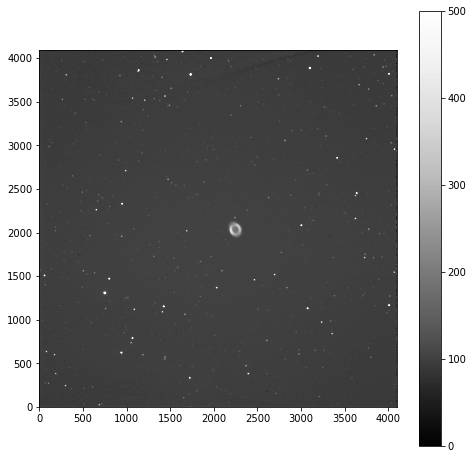

In [ ]:
plt.figure(figsize = (8,8))
plt.imshow(test_pixel_values, origin='lower', cmap = 'Greys_r',vmin = 0, vmax = 500)
plt.colorbar()

## Star identification

There are a lot of stars on these figures, and ideally, we would want to calculate a magnitude for each. Doing so and identifying each one-by-one would require a very long amount of time; hence we try to identify them automatically. This is done through astropy's *find_peaks* method. The basic principle is, that we know how much the background fluctuates; a lot less than the effect a star causes. Hence if we detect a peak on the figure, that is way more significant, than the actual fluctuations (say, for example, 10 times greater than the standard deviation of the background pixel counts), then we can safely flag that as a star (assuming the figure has been corrected to cosmic ray hits and/or overcharged pixels).

This step is done in the cells below. After the background level estimation, the script finds all peaks that exceed the standard deviation 15 times, while scanning with steps of 30 pixel at a time. Whereas this finds all peaks on the figure, we discard the ones at the edges (due to these being usually more prone to calibration errors, but excluding these makes the analysis also simpler).

These numbers were chosen empirically; feel free to change them, if you wish to experiment.

In [ ]:
# Estimate background level through sigma clipping
from astropy.stats import SigmaClip

sigma_clip = SigmaClip(sigma=3.) # Everything above 3 sigma will be clipped
bkg_estimator = background.MedianBackground()

# Estimate background level by looking at 50x50 cutouts
bkg = background.Background2D(test_pixel_values, (50, 50), filter_size=(3, 3),
                              sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

median_bkg = bkg.background_median
print("Median of background, Noise of background")
print(median_bkg, bkg.background_rms_median)

Median of background, Noise of background
98.575682230204 9.956248085361686


In [ ]:
# Find the stars/peaks on the image

# -----------------------------------------------------------

# There are two tuneable parameters here

SNR = 15      # Signal to noise ratio. This will set the limit for the peaks; anything above background fluctuations
              # times this number will be included. Basically this sets the brightness of the stars that will be included; 
              # the lower it is, the more fainter star will be in the sample.
        
box_size = 30 # This sets how close the peaks can be next to one another

# -----------------------------------------------------------

peak_table = find_peaks(test_pixel_values, bkg.background_rms_median * SNR, box_size = box_size)

The obtained table contains the list of peaks in the figure, but these contain several targets that we do not want to include; such as stars at the edges of the frame, which are more prone to calibration errors and some tweaking is required for their photometry, and hot pixels, which were missed by the reduction. These can be removed by combining two conditions.

### First remove everything that is on the edges of the figure. This condition can be further customized if additional areas have to be excluded.

In [ ]:
edge_lim = 50 # This sets how far off the image edges we start to include stars
cond1 = (peak_table['x_peak'] > edge_lim) & (peak_table['x_peak'] < test_pixel_values.shape[0] - edge_lim) & \
        (peak_table['y_peak'] > edge_lim) & (peak_table['y_peak'] < test_pixel_values.shape[1] - edge_lim)

### We also need to consider that there are significant amount of hot pixels left in the figure. To exclude these "peak"-s, we need to take a look at the pixels neighbouring the target one. These usually are not affected by the hot pixel, meaning they will only contain noise. Hence, we can take an area around the peak pixel, and if the median in that area significantly exceeds the noise level, then we probably have a real star; but if not, then the target is a hot pixel.

In [ ]:
cond2 = np.zeros(cond1.shape)
for i in range (cond2.shape[0]):
    # Check the median close to the target pixel
    close_median = np.median(test_pixel_values.T[peak_table['x_peak'][i] - 1 : peak_table['x_peak'][i] + 2,
                                                 peak_table['y_peak'][i] - 1 : peak_table['y_peak'][i] + 2])
    if close_median > 1.5 * median_bkg:
        cond2[i] = 1   # If exceeds, then it is a true detection
        
cond2 = cond2.astype(bool)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Now combine the two conditions and apply them on the table we obtained.

In [ ]:
cond_final = np.logical_and(cond1,cond2) # Combine the two conditions

peak_table = peak_table[cond_final]

The figure below shows the stars that were found, along with their ID-s, that will be used to flag them.

Keep in mind that the algorithm does not know what it looks at! This means, that if there is a nebula or something else on the figure, the script will also flag parts of it as stars. But ultimately this does not change the course of the analysis; we can just ignore these.

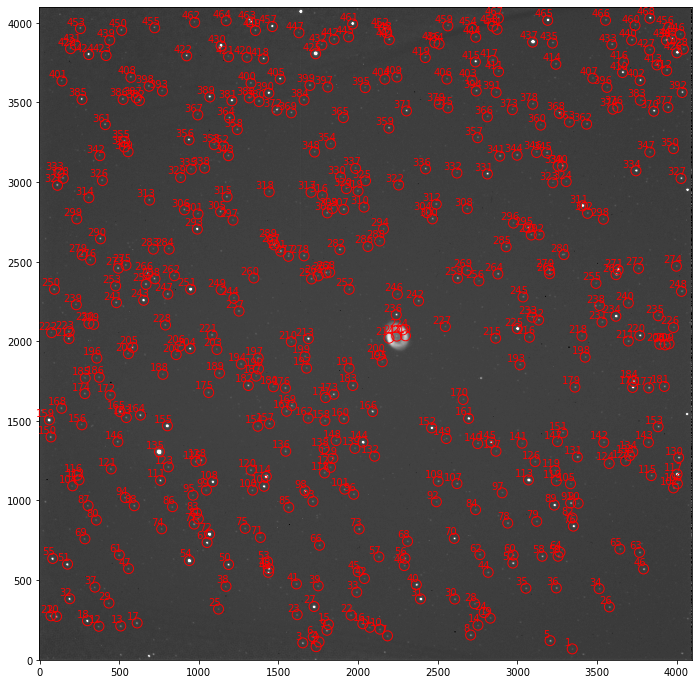

In [ ]:
plt.figure(figsize = (12,12))
plt.imshow(test_pixel_values, origin='lower', cmap = 'Greys_r',vmin = 0, vmax = 500)

plt.scatter(peak_table['x_peak'], peak_table['y_peak'], s=100, edgecolors='r', facecolors='none')
for i in range (len(peak_table)):
    plt.text(peak_table['x_peak'][i]-25, peak_table['y_peak'][i]+25, str(i+1),
             color = 'red', horizontalalignment = 'center')

### If things get confusing and crowded, we can zoom in a bit

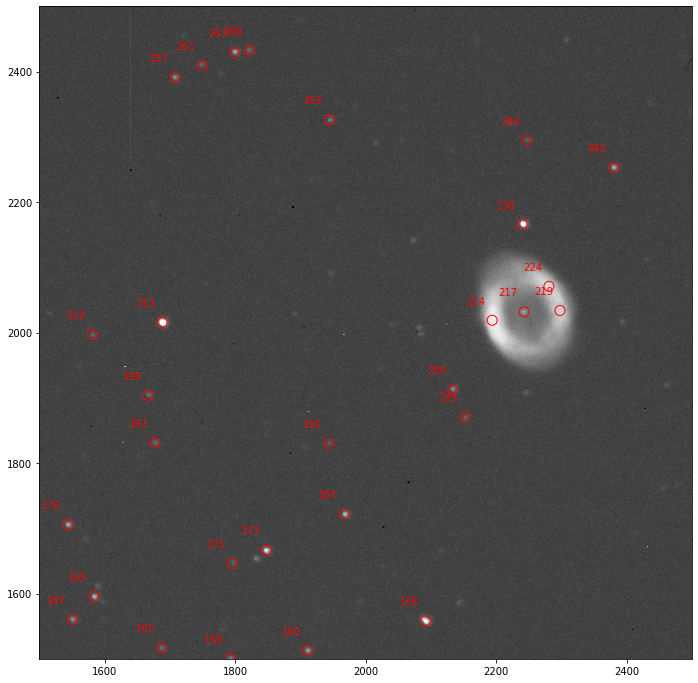

In [ ]:
plt.figure(figsize = (12,12))
plt.imshow(test_pixel_values, origin='lower', cmap = 'Greys_r',vmin = 0, vmax = 500)
plt.scatter(peak_table['x_peak'], peak_table['y_peak'], s=100, edgecolors='r', facecolors='none')


# The X and Y limits in pixels for the figure
x_lims = [1500, 2500]
y_lims = [1500, 2500]

plt.xlim(x_lims[0],x_lims[1])
plt.ylim(y_lims[0],y_lims[1])
for i in range (len(peak_table)):
    if peak_table['x_peak'][i] > x_lims[0] and peak_table['x_peak'][i] < x_lims[1] and \
        peak_table['y_peak'][i] > y_lims[0] and peak_table['y_peak'][i] < y_lims[1]:
        plt.text(peak_table['x_peak'][i]-25, peak_table['y_peak'][i]+25, str(i+1),
                 color = 'red', horizontalalignment = 'center')

The updated peak table contains the x and y coordinates of the found targets along with their highest pixel values.

In [ ]:
peak_table

<QTable length=468>
x_peak y_peak     peak_value    
int64  int64       float64      
------ ------ ------------------
  3345     68  167.3488142528819
  1737     82 199.33047044671065
  1653    106 448.22146853074355
  1755    112 170.26215193548538
  3206    120 507.27514138533394
  1719    144  256.8068490925961
  2185    150  213.6091614744141
  2707    155  424.5722645476757
  1805    185  359.1623945396571
  2138    192  207.7578017767612
   ...    ...                ...
  2564   3980  228.4906167051444
  3739   3982 213.50610541346646
  1966   3992  4181.966756001518
   974   4002 193.73970671674292
  1328   4004 1100.8543363834096
  1172   4012 273.78693864880364
  3191   4015  2399.920688140214
  3554   4015  286.6413418918202
  2881   4028  250.0465582375908
  3832   4028  1264.335528541024

**From these images we can tell how good is our star identification method. There may be a few stars that are not identified, but then those would also be less reliable.** 

Tweaking the parameters for the peak finder method can help in identifying the stars that were not marked before (by lowerint the SNR limit), but bear in mind that this also increases the chance for noisier targets to be included.

# **Let's try to do the photometry for a single star on the frame!**

Using this, we will determine the size of the aperture needed for the analysis, which we will use afterwards for all the stars. To carry this out, we first need to pick a star that is suitably bright, not saturated, and is reasonably separated from the other objects in the frame. Look for such objects in the above figures by modifying the plotting range!

In [ ]:
# Define a function to cut out the stars one by one

def get_cutout(ind, pixel_data):
    
    position = (peak_table['x_peak'][ind], peak_table['y_peak'][ind])  # Where the cutout should be centered; where the star is
    size = (100, 100)     # The size of the cutout in pixels
    star1 = Cutout2D(pixel_data, position, size) # The cutout is made here
    
    return star1

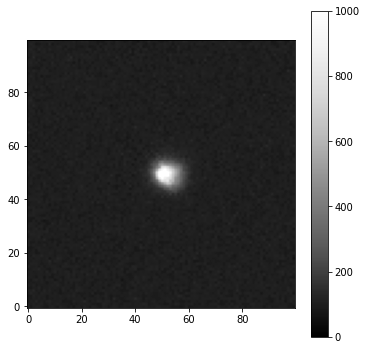

In [ ]:
i = 212  # Set the index to the ID of the chosen star MINUS 1! (StarID - 1)

star1 = get_cutout(i, test_pixel_values)

plt.figure(figsize = (6,6))
plt.imshow(star1.data, origin='lower', cmap = 'Greys_r', vmin = 0, vmax = 1000)
plt.colorbar()

Imagine this figure as a bottom of a bucket; each pixel defines a position while the color tells us how many photons were dropped onto that position. A 3d plot grasps this aspect better:

Text(0.5, 0, 'Pixel count')

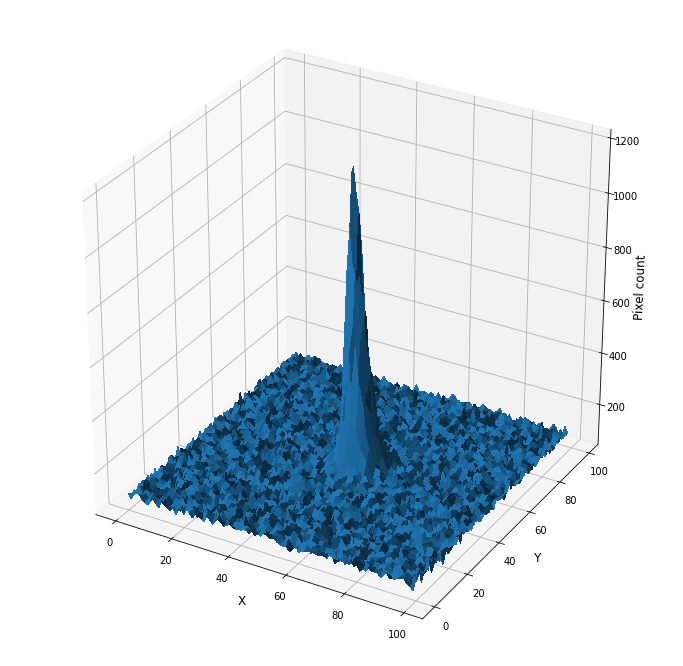

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')

xx = np.linspace(0, star1.data.shape[0] - 1, star1.data.shape[0])
X, Y = np.meshgrid(xx, xx)
ax.plot_surface(X, Y, star1.data, linewidth=1, antialiased=False)

ax.set_xlabel('X', fontsize = 12)
ax.set_ylabel('Y', fontsize = 12)
ax.set_zlabel('Pixel count', fontsize = 12)

#### This is the 3D representation of the image above; the x and y axes show the pixel coordinates, while the z axis show the CCD counts.
The background fluctuation can clearly be seen, whereas the peak in the middle shows where the star is

What we essentially want to do, is to caluclate how many counts were acquired in the region where the star is, then compare it with other stars. However, this is a tricky step, since we need to find a region on the cutout, which contains _only_ the star we want to estimate the brightness for. Ideally, we want to limit this region so that the edge of it would be on the "foot of the pixel mountain", i.e. still in the region that is dominated by the flux from the star. Having a larger one is not a problem either; unless there are other stars in the cutout.

Given that we are working with clusters, stars can get very close to each other; in that case, a smaller aperture has to be used for the calculation. On the other hand, brighter stars take up more space on the figure, hence in their case, a wider aperture has to chosen. To balance out these effects, and choose the right aperture size for the analysis, we have to take a look a well-exposed star, and carry out its photometry by varying the aperture size, then pick the best one.

#### **One example on photometry with different aperture sizes can be seen below** 

Here the aperture size is increased at each step and the photometry is carried out with each. The basic idea is that the number of counts (after subtracting the background) are summed simply within the aperture. 

On the figure below you can see that the number off counts levels off at some point when compared to the aperture size, meaning that there is a charachteristic smallest radius which already contains all the flux from the star.

In [ ]:
apss = []

# Position of the star on the cut-out; should be in the middle
pos = (int(star1.data.shape[0]/2), int(star1.data.shape[0]/2))

# The background, which has to be evaluated for each cut-out
bkg = background.Background2D(star1.data, (30, 30), filter_size=(3, 3),
                              sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

for i in range (20):
    # Set up a circular aperture at a given position with a given radius
    obj_aperture = CircularAperture(pos, r=i+1)

    # Carry out the photometry; the resulting table will contain the sum of the counts
    # Don't forget to subtract the background; if it is non-zero, it would bias the photometry
    obj_table = aperture_photometry(star1.data - bkg.background_median, obj_aperture) 
    
    apss.append(obj_table['aperture_sum'])    
    
# To get the best radius, simply look at how the number of counts changes within the apertures
# as we increase the radius. The charachteristic point is where the counts start levelling off
# and they reach the 90% of the maximal value. After this, we simply apply a calibrator factor
# on the aperture size (1.25 here), with which the aperture covers the entire star.

best_radius = 1.25 * (np.abs(np.array(apss) - 0.9 * max(apss))).argmin()

Let's plot what exactly happens here!

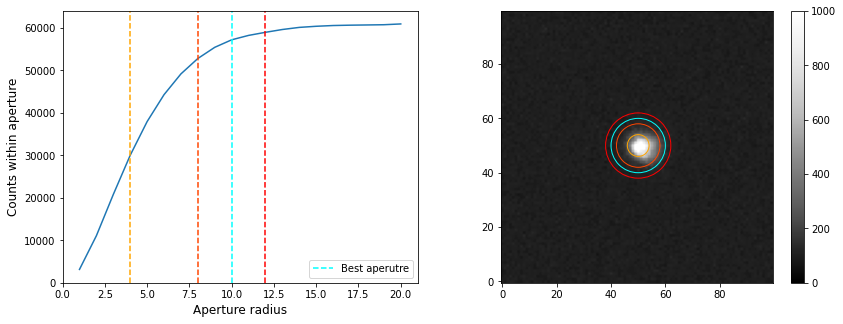

In [ ]:
f = plt.figure(figsize = (14,5))
ax = f.add_subplot(1,2,1)
plt.plot(np.arange(1,21,1), apss)

plt.axvline(4, ls = '--', color = 'orange')
plt.axvline(8, ls = '--', color = 'orangered')
plt.axvline(12, ls = '--', color = 'red')
plt.axvline(best_radius, ls = '--', color = 'aqua', label = 'Best aperutre')

plt.legend()

plt.xlim(0, 21)
plt.ylim(0, 1.05 * max(apss))

plt.xlabel('Aperture radius', fontsize = 12)
plt.ylabel('Counts within aperture', fontsize = 12)

ax = f.add_subplot(1,2,2)
plt.imshow(star1.data, origin='lower', cmap = 'Greys_r', vmin = 0, vmax = 1000)
plt.colorbar()

circle1 = plt.Circle(pos, 4, color = 'None', ec = 'orange')
ax.add_patch(circle1)
circle2 = plt.Circle(pos, 8, color = 'None', ec = 'orangered')
ax.add_patch(circle2)
circle3 = plt.Circle(pos, 12, color = 'None', ec = 'red')
ax.add_patch(circle3)
circle4 = plt.Circle(pos, best_radius, color = 'None', ec = 'aqua')
ax.add_patch(circle4)

The left figure shows the so-called growth curve, or the number of counts within the aperture for changing aperture sizes, while the right figure compares these on top of the star. The aqua-blue circle shows the best aperture.

### Once the aperture size is set, we can proceed to the actual photometry, which can be done in a single row.

It is important to bear in mind that the background has to be subtracted here too.

In [ ]:
bkg = background.Background2D(star1.data, (30, 30), filter_size=(3, 3),
                              sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

obj_aperture = CircularAperture((int(star1.data.shape[0]/2), int(star1.data.shape[0]/2)), r=best_radius)
obj_table = aperture_photometry(star1.data - bkg.background_median, obj_aperture)
obj_table

<QTable length=1>
  id  xcenter ycenter    aperture_sum  
        pix     pix                    
int64 float64 float64      float64     
----- ------- ------- -----------------
    1    50.0    50.0 57190.65623409476

### **Let's do this procedure for all the stars!** 

The script below runs the above task to all the stars, and in turn, we get a list of counts for each of the stars in the figure

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# The DataFrame with the final results. This will be filled iteratively.
frame_count_table = pd.DataFrame()

for i in range (len(peak_table)):

    star1 = get_cutout(i, test_pixel_values)
    
    bkg = background.Background2D(star1.data, (30, 30), filter_size=(3, 3),
                              sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    
    target_position = (int(star1.data.shape[0]/2), int(star1.data.shape[1]/2))

    obj_aperture = CircularAperture(target_position, r = best_radius)
    obj_table = aperture_photometry(star1.data - bkg.background_median, obj_aperture)
    
    temp = pd.Series([i+1, peak_table['x_peak'][i], peak_table['y_peak'][i], obj_table['aperture_sum'][0]],
                     ['Star_ID', 'X_c', 'Y_c', 'Count'])
    
    # Star_ID: the number of the star from the table
    # X_c and Y_c: the X and Y pixel coordinates in the frame
    # Counts: the acquired number of counts within the aperture

    frame_count_table = frame_count_table.append(temp, ignore_index = True)

Now, we have the intensity counts for all the stars in the frame. What we need to do now, is to convert this to magnitudes, which we can interpret. For this, we have to find a star in the figure, for which we know the exact brightness value. 

This step can be done through multiple webpages. The one we recommend using is the aladin website: https://aladin.u-strasbg.fr/AladinLite/ Here, one can compare the observed frame to various catalogues, then can identify stars and check their magnitudes. See an example figure for the interface below.

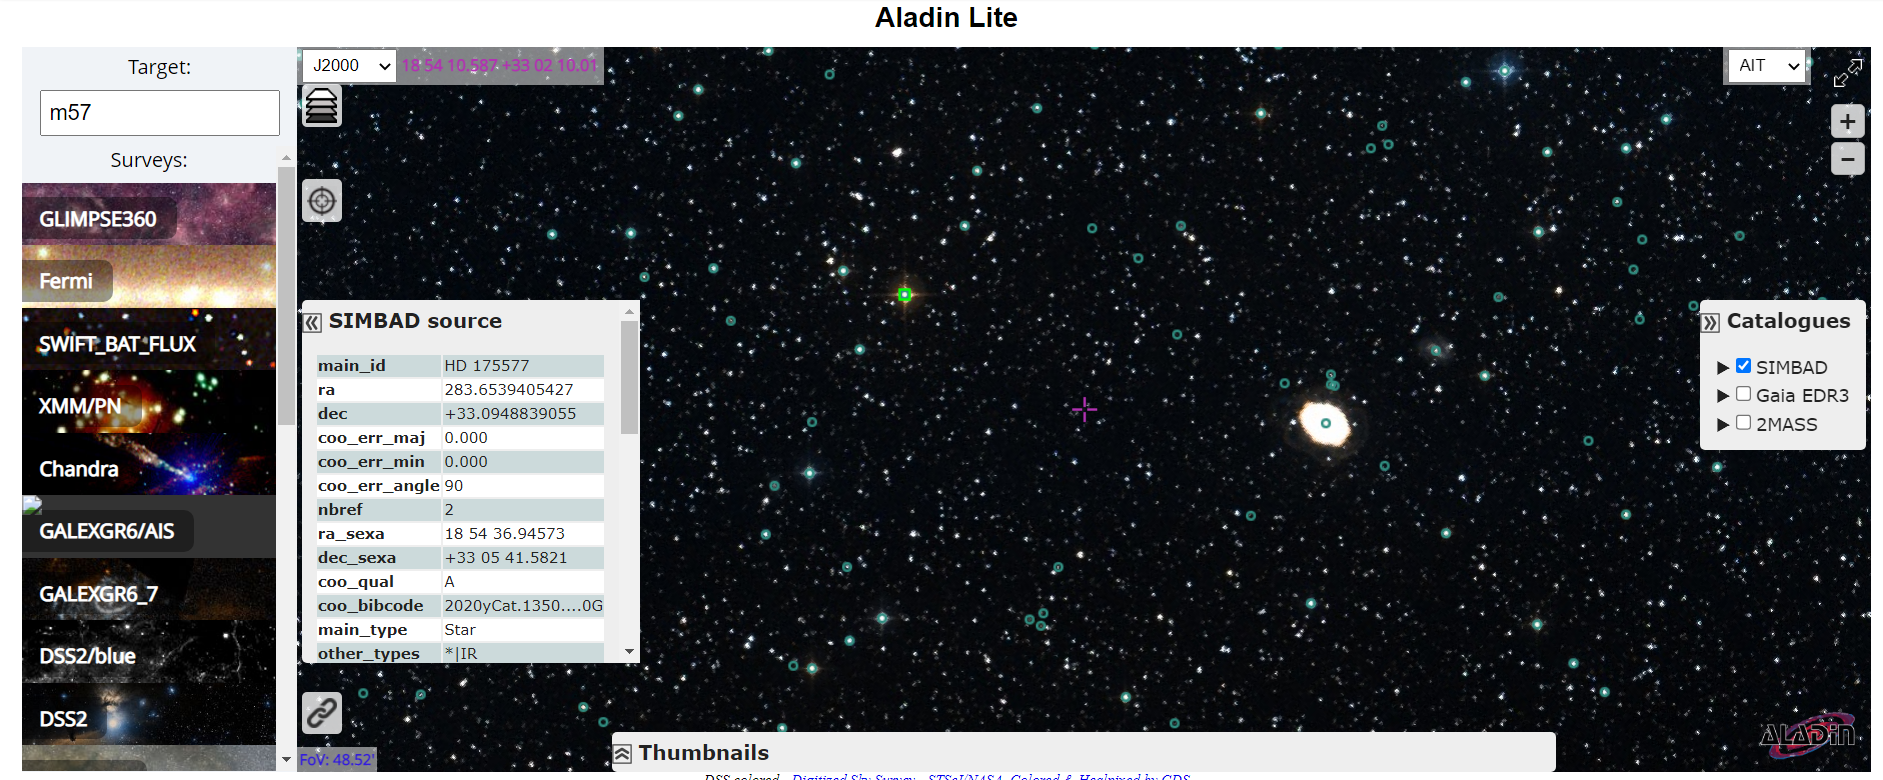

Below we included some dummy data to show how this can be done. First, one has to pick an object ID, for which the magnitude is known, then note down its magnitude. This can be done for multiple objects; the more included, the more precise will the final magnitudes be. Just make sure that the IDs and magnitudes don't get mixed up.

## *Keep in mind that the orientation of the Aladdin maps and our figure can be significantly different!*

For a qualitative analysis, it is enough to set the magnitudes of only one star, and it can be set to any arbitrary value. Whereas this obviously leads to an offset along both the magnitude and color axes on the CMD, it will not affect their shapes. However, to obtain relative distances and ages between clusters, it is required to set the zero-points properly.

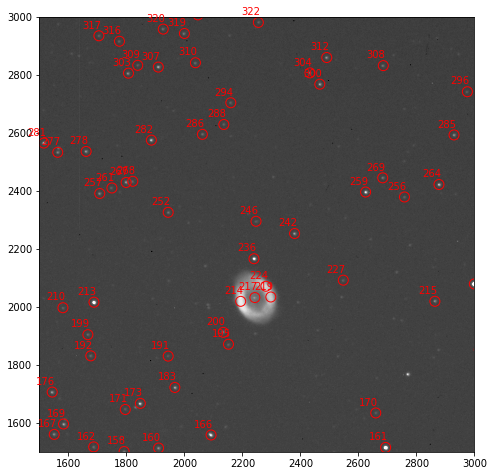

In [ ]:
# Use the image cutout and hunt for stars that you recognize in Aladdin and that have a measured magnitude!

plt.figure(figsize = (8,8))
plt.imshow(test_pixel_values, origin='upper', cmap = 'Greys_r',vmin = 0, vmax = 500)
plt.scatter(peak_table['x_peak'], peak_table['y_peak'], s=100, edgecolors='r', facecolors='none')

x_lims = [1500, 3000]
y_lims = [1500, 3000]

plt.xlim(x_lims[0],x_lims[1])
plt.ylim(y_lims[0],y_lims[1])
for i in range (len(peak_table)):
    if peak_table['x_peak'][i] > x_lims[0] and peak_table['x_peak'][i] < x_lims[1] and \
        peak_table['y_peak'][i] > y_lims[0] and peak_table['y_peak'][i] < y_lims[1]:
        plt.text(peak_table['x_peak'][i]-25, peak_table['y_peak'][i]+25, str(i+1),
                 color = 'red', horizontalalignment = 'center')

Setting the results and getting the magnitudes works as shown below.

In [ ]:
ID_ref = [41]

ind_ref = np.array([list(frame_count_table['Star_ID']).index(ID_ref[i]) for i in range (len(ID_ref))])

mag_ref_list = np.array([9.1])

mags = np.zeros((len(frame_count_table)))

for i in range (len(frame_count_table)):   # The implementation of the flux/counts --> magnitude formula
    mags[i] = np.average([-2.5 * np.log10(frame_count_table['Count'][i]/frame_count_table['Count'][ind_ref[j]]) \
                          + mag_ref_list[j] for j in range (len(ind_ref))])

frame_count_table['Mag'] = mags 

### The results are then summarized in a final table of magnitudes

In [ ]:
frame_count_table

Star_ID     X_c     Y_c         Count       Mag
0        1.0  3345.0    68.0   3184.589217  9.821218
1        2.0  1737.0    82.0   3161.998494  9.828948
2        3.0  1653.0   106.0  18287.126022  7.923488
3        4.0  1755.0   112.0   3204.373726  9.814494
4        5.0  3206.0   120.0  18023.594304  7.939248
..       ...     ...     ...           ...       ...
463    464.0  1172.0  4012.0   7697.823904  8.862932
464    465.0  3191.0  4015.0  97912.842861  6.101753
465    466.0  3554.0  4015.0   7305.665700  8.919702
466    467.0  2881.0  4028.0   6452.818032  9.054478
467    468.0  3832.0  4028.0  45109.493899  6.943182

[468 rows x 5 columns]

### This was the basic outline of the procedure. To obtain a CMD, one has to carry this out for both the Blue, Green and Red band images too. This is done by the script below; only the filenames have to be modified to get the correct result.

In [ ]:
# Check the order of the files!
observation_files

In [ ]:
# Assume that the frames are well aligned; i.e. there is no need for rotational corrections and such, so we can use the same
# peak_tab as before

Blue_o_arr = fits.open(path_to_obs + observation_files[0])[0].data.astype(float)
Green_o_arr = fits.open(path_to_obs + observation_files[1])[0].data.astype(float)
Red_o_arr = fits.open(path_to_obs + observation_files[2])[0].data.astype(float)


# List of frames in different bands; they should be in the order of B G R for this script to work properly
corr_arr_s = [Blue_o_arr, Green_o_arr, Red_o_arr]
bandlist = ['B', 'G', 'R']

final_count_table = pd.DataFrame()

for i in range (len(peak_table)):   # Goes through all the detected stars; use the same peak table as before
    
    count_vls = []
    added_bands = []
    
    try:
        for j in range (len(corr_arr_s)):  # Goes through the different bands

            star1 = get_cutout(i, corr_arr_s[j])
            
            bkg = background.Background2D(star1.data, (30, 30), filter_size=(3, 3),
                              sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

            target_position = (int(star1.data.shape[0]/2), int(star1.data.shape[0]/2))
            
            obj_aperture = CircularAperture(target_position, r=best_radius)
            obj_table = aperture_photometry(star1.data - bkg.background_median, obj_aperture)

            count_vls.append(obj_table['aperture_sum'][0])
            added_bands.append(bandlist[j] + '_count')
            
    except (TypeError, ValueError):
        continue     # It sometimes happens that there are no intensity peaks in the cutouts taken in bands that are different
                     # from the one we used to calculate the peak_tab. This can happen when the original peak was due to an
                     # artifact; hot pixels and such. Better leave these out.
    
    row = [i+1, peak_table['x_peak'][i], peak_table['y_peak'][i]]
    row.extend(count_vls)
    
    colnames = ['Star_ID', 'X_c', 'Y_c']
    colnames.extend(added_bands)
    
    temp = pd.Series(row, colnames)
    
    final_count_table = final_count_table.append(temp, ignore_index = True)

In [ ]:
final_count_table

Star_ID     X_c     Y_c        B_count        G_count       R_count
0        1.0  3345.0    68.0   10975.190172    7216.453363   3184.589217
1        2.0  1737.0    82.0   12645.605894    6961.746901   3161.998494
2        3.0  1653.0   106.0   35650.200569   27238.600658  18287.126022
3        4.0  1755.0   112.0   10690.174513    5626.148890   3204.373726
4        5.0  3206.0   120.0   35906.425467   27727.291243  18023.594304
..       ...     ...     ...            ...            ...           ...
463    464.0  1172.0  4012.0   17896.806409   12412.267488   7697.823904
464    465.0  3191.0  4015.0  148639.732764  141665.557973  97912.842861
465    466.0  3554.0  4015.0   16934.719480   12213.047823   7305.665700
466    467.0  2881.0  4028.0   16382.453746    6497.282530   6452.818032
467    468.0  3832.0  4028.0  148056.952896   99226.903557  45109.493899

[468 rows x 6 columns]

### This table contains the number of acquired counts for each of the stars on the three frames in the different filtes.

Turning the counts to magnitudes requires the same steps as above. Find a star, set its magnitudes (in both filters now), then simply convert the counts to magnitudes.

In [ ]:
ID_ref = [41]

ind_ref = np.array([list(final_count_table['Star_ID']).index(ID_ref[i]) for i in range (len(ID_ref))])

mag_ref_B = np.array([9.140])
mag_ref_V = np.array([9.140])
mag_ref_R = np.array([9.000])

B_mags = np.zeros((len(final_count_table)))
G_mags = np.zeros((len(final_count_table)))
R_mags = np.zeros((len(final_count_table)))

for i in range (len(final_count_table)):
    B_mags[i] = np.average([-2.5 * np.log10(final_count_table['B_count'][i]/final_count_table['B_count'][ind_ref[j]]) \
                            + mag_ref_B[j] for j in range (len(ind_ref))])
    G_mags[i] = np.average([-2.5 * np.log10(final_count_table['G_count'][i]/final_count_table['G_count'][ind_ref[j]]) \
                            + mag_ref_V[j] for j in range (len(ind_ref))])
    R_mags[i] = np.average([-2.5 * np.log10(final_count_table['R_count'][i]/final_count_table['R_count'][ind_ref[j]]) \
                            + mag_ref_R[j] for j in range (len(ind_ref))])

final_count_table['B'] = B_mags 
final_count_table['G'] = G_mags 
final_count_table['R'] = R_mags 

The final dataframe, that includes the magnitude values as well

In [ ]:
final_count_table
#final_count_table.to_csv('./test_data.csv')

Star_ID     X_c     Y_c        B_count        G_count       R_count  \
0        1.0  3345.0    68.0   10975.190172    7216.453363   3184.589217   
1        2.0  1737.0    82.0   12645.605894    6961.746901   3161.998494   
2        3.0  1653.0   106.0   35650.200569   27238.600658  18287.126022   
3        4.0  1755.0   112.0   10690.174513    5626.148890   3204.373726   
4        5.0  3206.0   120.0   35906.425467   27727.291243  18023.594304   
..       ...     ...     ...            ...            ...           ...   
463    464.0  1172.0  4012.0   17896.806409   12412.267488   7697.823904   
464    465.0  3191.0  4015.0  148639.732764  141665.557973  97912.842861   
465    466.0  3554.0  4015.0   16934.719480   12213.047823   7305.665700   
466    467.0  2881.0  4028.0   16382.453746    6497.282530   6452.818032   
467    468.0  3832.0  4028.0  148056.952896   99226.903557  45109.493899   

            B         G         R  
0    9.409515  9.411238  9.721218  
1    9.255696  9.450252  9.728948  
2    8.130390  7.969085  7.823488  
3    9.438083  9.681519  9.714494  
4    8.122614  7.949779  7.839248  
..        ...       ...       ...  
463  8.878606  8.822420  8.762932  
464  6.580207  6.178887  6.001753  
465  8.938600  8.839987  8.819702  
466  8.974597  9.525218  8.954478  
467  6.584473  6.565474  6.843182  

[468 rows x 9 columns]

### We can then export this DataFrame using final_count_table.to_csv() and plot the CMD based on it

# ------------------------------------------------------------------------------------------------------------

# The below scripts can only work if one is working with open cluster data; for a random field, they will not be meaningful

Below you will find an example script that can be used for CMD plotting

In [ ]:
def plot_CMD(band1, band2, df, vmi = None, vma = None):   # band1 and band2 are the to-be-plotted columns, df is the DataFrame
    if vmi == None:
        plt.scatter(df[band1] - df[band2], df[band2], s = 10, c = df[band1] - df[band2], cmap = 'coolwarm')
    else:
        plt.scatter(df[band1] - df[band2], df[band2], s = 10, c = df[band1] - df[band2], cmap = 'coolwarm',
                    vmin = vmi, vmax = vma)
    plt.gca().invert_yaxis()

    plt.xlabel(band1 + '$-$' + band2, fontsize = 12)
    plt.ylabel(band2, fontsize = 12)

Now we only need to plot the CMDs; the colours go on the x axis, while the magnitudes go on the y axis.

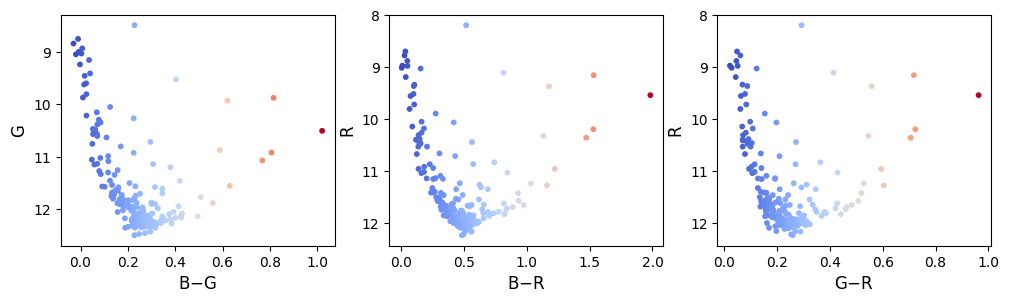

In [ ]:
f = plt.figure(figsize = (12,3))

# Assuming df contains the magnitude table

ax = f.add_subplot(1,3,1)
plot_CMD('B', 'G', df)

ax = f.add_subplot(1,3,2)
plot_CMD('B', 'R', df)

ax = f.add_subplot(1,3,3)
plot_CMD('G', 'R', df)

The main sequence is drawn out pretty nicely; however, there are a lot of outlier stars. Some of these are outliers due to not being part of the open cluster; given that we have applied the photometry on all the stars in the frame, we potentially include objects outside the cluster. To remove these, we can simply apply a constraint based on the position of the stars in the frame.

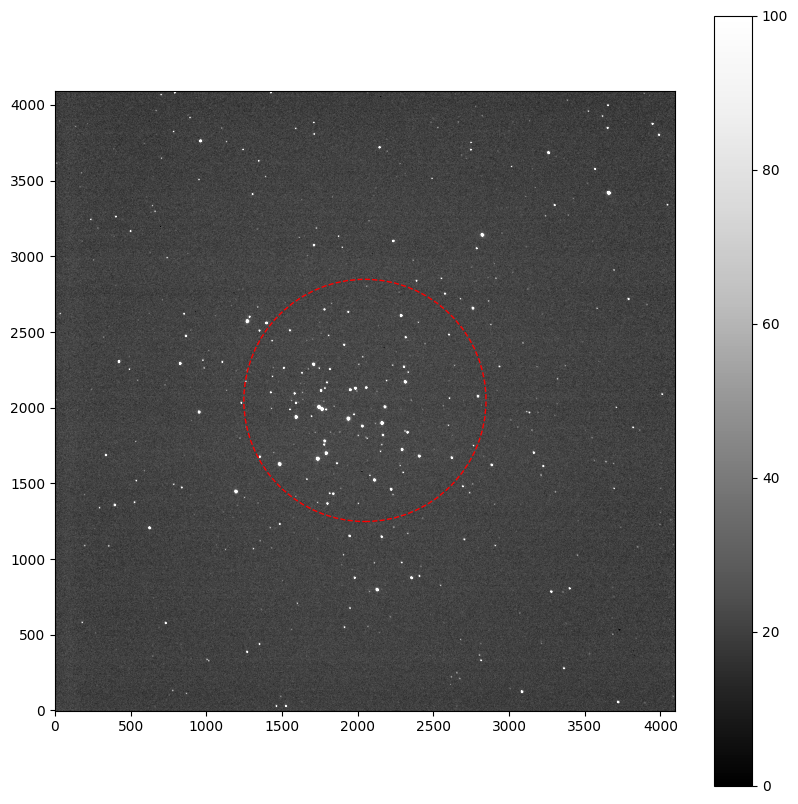

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(corr_arr, origin='lower', cmap = 'Greys_r',vmin = 0, vmax = 100)


center_of_frame = (int(corr_arr.shape[0]/2), int(corr_arr.shape[1]/2))  # This is the center, where the open cluster should be
radius = 800   # The observed radius of the open cluster, this has to be set manually

# We performed the photometry for the whole frame, but most likely some of the stars are not cluster members. The easiest way to
# remove these from the sample is to apply a constrain on the observed distance from the cluster; or to include only the stars
# that fall into the circle we draw.

circle1 = plt.Circle(center_of_frame, radius, color = 'None', ec = 'red', ls = '--')
ax.add_patch(circle1)
plt.colorbar()

In [ ]:
# Condition to tell, whether the stars are in the circle plotted above or not
pos_cond = np.sqrt(np.square(df['X_c'] -  center_of_frame[0]) + np.square(df['Y_c'] -  center_of_frame[1])) < radius

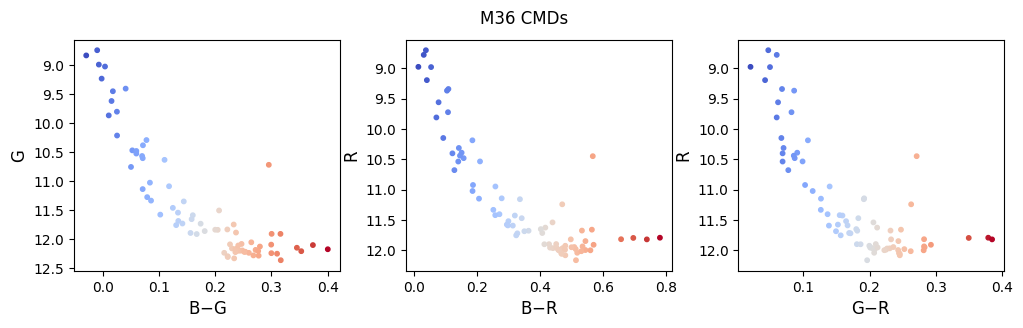

In [ ]:
f = plt.figure(figsize = (12,3))
f.subplots_adjust(wspace = 0.25)

plt.suptitle('M36 CMDs', fontsize = 12)

ax = f.add_subplot(1,3,1)
plot_CMD('B', 'G', df[pos_cond])

ax = f.add_subplot(1,3,2)
plot_CMD('B', 'R', df[pos_cond])

ax = f.add_subplot(1,3,3)
plot_CMD('G', 'R', df[pos_cond])

And indeed, most of the outlier objects were succesfully removed, leaving us with the main sequence of the open cluster clearly visible.

## And this is it basically, this is what we wanted to achieve